# Daily statistics from six-hourly SEAS5 data

In [10]:
# If first time running, uncomment the line below to install any additional dependancies
# !bash requirements-for-notebooks.sh

In [11]:
from earthkit.transforms import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file
ek_data.settings.set("cache-policy", "user")

import matplotlib.pyplot as plt

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use three initialisation of the SEAS5 2m temperature data on a 1.x1. spatial grid. The temporal resolution is 6 hourly, and we have the forecasts for January, February and March 2015.

First we download (if not already cached) and lazily load the SEAS5 data (please see tutorials in `earthkit-data` for more details in cache management).

We inspect the data using the to_xarray method and see we have some 2m air temperature data. Using the xarray representation each of the dimensions can be queried.

In [12]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_seas5_file = earthkit_remote_test_data_file("test-data", "seas5_2m_temperature_201501-201503_europe_1deg.grib")
seas5_data = ek_data.from_source("url", remote_seas5_file)
seas5_xr = seas5_data.to_xarray()
seas5_data.to_xarray()

<xarray.Dataset> Size: 91MB
Dimensions:     (number: 25, time: 3, step: 239, surface: 1, latitude: 31,
                 longitude: 41)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 24B 2015-01-01 2015-02-01 2015-03-01
  * step        (step) timedelta64[ns] 2kB 0 days 06:00:00 ... 59 days 18:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude   (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
    valid_time  (time, step) datetime64[ns] 6kB ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 91MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:58 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate the daily median of the Seasonal Forecast data

In this first example we will handle the forecast initialisations independently, i.e. return the daily median of the 3 different forescasts. To do this we must specifiy that the time-dimension we wish to calculate the aggregation over is the "step" dimension.

In [13]:
seas_daily_median_by_step = ek_aggregate.temporal.daily_median(
    seas5_xr, time_dim="step"
)
seas_daily_median_by_step.coords["valid_time"] = (
    seas_daily_median_by_step["time"] + seas_daily_median_by_step["step"]
)
seas_daily_median_by_step

<xarray.Dataset> Size: 23MB
Dimensions:     (step: 60, number: 25, time: 3, surface: 1, latitude: 31,
                 longitude: 41)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 24B 2015-01-01 2015-02-01 2015-03-01
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude   (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * step        (step) timedelta64[ns] 480B 0 days 06:00:00 ... 59 days 06:00:00
    valid_time  (time, step) datetime64[ns] 1kB 2015-01-01T06:00:00 ... 2015-...
Data variables:
    t2m         (step, number, time, surface, latitude, longitude) float32 23MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:58 GRIB to CDM+CF via cfgrib-0.9.1...

In [14]:
seas5_daily_median_by_vt = ek_aggregate.temporal.daily_median(seas5_data, time_dim="valid_time")
seas5_daily_median_by_vt

<xarray.Dataset> Size: 15MB
Dimensions:    (date: 119, number: 25, surface: 1, latitude: 31, longitude: 41)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * date       (date) datetime64[ns] 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m        (date, number, surface, latitude, longitude) float32 15MB 269....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-12T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot a random point location to see the different aggregation methods

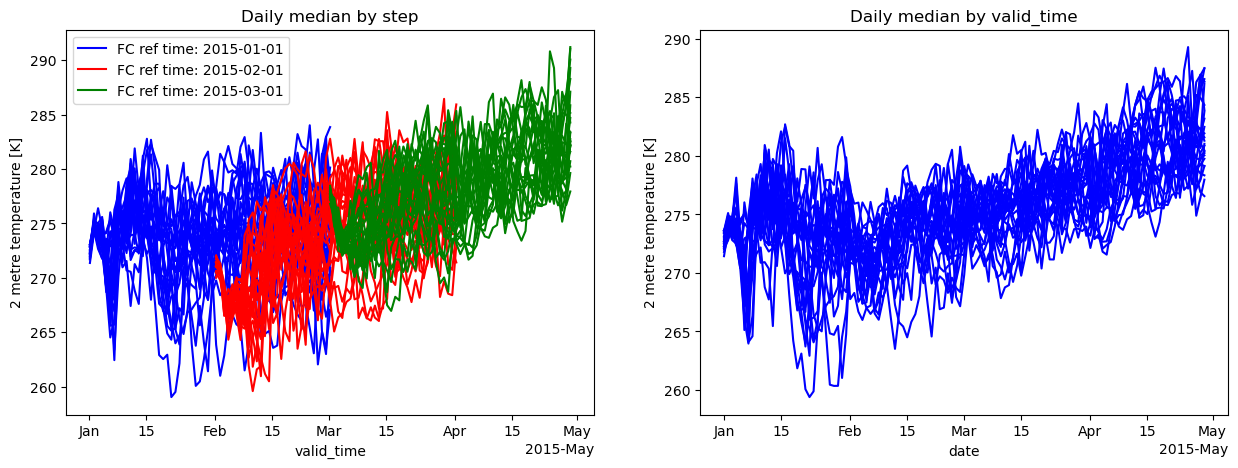

In [15]:
isel_kwargs = {"latitude":20, "longitude":20}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

forecast_colours = ["blue", "red", "green"]

# era5_data.to_xarray().t2m.isel(**isel_kwargs).plot(label='Raw data', ax=ax)
f_kwargs = {"label": "Daily median over step"}

for itime in range(3):
    for number in range(25):
        t_data = seas_daily_median_by_step.t2m.isel(**isel_kwargs, number=number, time=itime)
        if number == 0:
            extra_kwargs = {"label": f"FC ref time: {str(t_data.time.values)[:10]}"}
        else:
            extra_kwargs = {}
        t_data.plot(
            x = "valid_time",
            ax=axes[0], color=forecast_colours[itime], **extra_kwargs
        )
axes[0].legend(loc=2)
axes[0].set_title("Daily median by step")

for number in range(25):
    t_data = seas5_daily_median_by_vt.t2m.isel(**isel_kwargs, number=number)
    extra_kwargs = {}
    t_data.plot(
        x = "date",
        ax=axes[1], color=forecast_colours[0], **extra_kwargs
        )

axes[1].set_title("Daily median by valid_time")

plt.show()